# Multi-Class Image Classifier - Intel Image classification data

This notebook uses Tensorflow and Keras to create a Convolutional Neural network to classify images of 6 classes of natural and urban images.

The first code cell imports the required libraries. 

The dataset used is the Intel Image Classification dataset downloaded from Kaggle and contains 14034 labeled images in the training set, 3000 labeled images used for validation, and 7301 unlabeled images for testing.

The classes in the dataset are : 


*   Glaciers
*   Mountains
*   Sea
*   Forest
*   Street
*   Buildings








In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
 !pip install -q kaggle

In [ ]:
from google.colab import files

files.upload() #upload Kaggle json file from PC, containing API Token

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json   #change permissions for the directory
! kaggle datasets download -d 'puneet6060/intel-image-classification'  #download dataset

 93% 321M/346M [00:03<00:00, 61.0MB/s]
100% 346M/346M [00:03<00:00, 93.9MB/s]


In [ ]:
! unzip intel-image-classification.zip -d intel_img  #unzip data to local folder

In [ ]:
!ls 

intel-image-classification.zip	intel_img  kaggle.json	sample_data


In [ ]:
os.listdir('/content/intel_img/seg_train/seg_train')

['sea', 'forest', 'mountain', 'street', 'buildings', 'glacier']

In [ ]:

train_dir = '/content/intel_img/seg_train/seg_train'
validation_dir = '/content/intel_img/seg_test/seg_test'
test_dir = '/content/intel_img/seg_pred'

# Variables for pre-processing and training.
batch_size = 250
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150


Next we create image generators for each of the three image data sets (train, validation, test) using `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. We use the `rescale` argument  to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, we use the `flow_from_directory` method. We pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required.
The 'test_data' is unlabeled and therefore the directory path does not contain any labels, unlike the train and validation data.


In [ ]:
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
	 target_size=(IMG_HEIGHT, IMG_WIDTH),
	class_mode='categorical',
  batch_size=128)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
	 target_size=(IMG_HEIGHT, IMG_WIDTH),
	class_mode='categorical',
  batch_size=128)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
	 target_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=128,
  shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list.
Running the cell below will plot five random training images.

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          
          prob = probability.max()
          label_index = probability.argmax()
          class_labels = (train_data_gen.class_indices)
          class_labels = dict((v,k) for k,v in class_labels.items())
          predicted_label = class_labels[label_index]
          
          ax.set_title("%.2f" % (prob*100) + " " + predicted_label)
          
           
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

We add 6 random transformations as arguments to `ImageDataGenerator`.


In [ ]:
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
	    rotation_range=20,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


 `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 14034 images belonging to 6 classes.


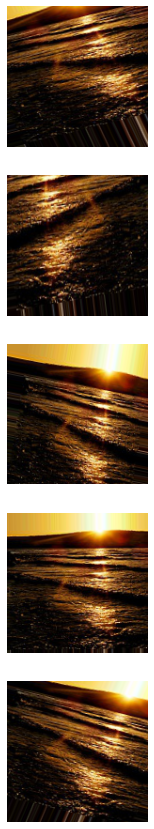

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, we create a model for the neural network that outputs class probabilities. It uses the Keras Sequential model and involves a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.
This is then fed to a dense network with the final layer being a single neuron with a sigmoid activation function, to give probability.

We then compile the model passing the arguments to set the optimizer and loss. 

In [ ]:
model = Sequential([
    #1st convolution
    Conv2D(100, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=2, strides=2),
    #2nd convolution
    Conv2D(120, (3,3), activation='relu'),
    
    #3rd convolution
    Conv2D(120, (3,3), activation='relu'),

    #4th convolution
    Conv2D(164, (3,3), activation='relu'),
    
    #5th convolution
    Conv2D(128, (3,3), activation='relu'),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    #flatten the output of the convolutions to feed to the dense network
    Flatten(),
    Dropout(0.5),
    
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 120)       108120    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 70, 70, 120)       129720    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 68, 68, 164)       177284    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 66, 66, 128)       189056    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
history = model.fit(x=train_data_gen, epochs=20, validation_data = val_data_gen, verbose = 1)

Epoch 1/20
57/57 [==============================] - 103s 2s/step - loss: 1.4288 - accuracy: 0.4193 - val_loss: 1.0507 - val_accuracy: 0.5753
Epoch 2/20
57/57 [==============================] - 100s 2s/step - loss: 1.0358 - accuracy: 0.5843 - val_loss: 0.9232 - val_accuracy: 0.6210
Epoch 3/20
57/57 [==============================] - 100s 2s/step - loss: 0.9508 - accuracy: 0.6275 - val_loss: 0.9588 - val_accuracy: 0.6207
Epoch 4/20
57/57 [==============================] - 100s 2s/step - loss: 0.8776 - accuracy: 0.6604 - val_loss: 0.7731 - val_accuracy: 0.7180
Epoch 5/20
57/57 [==============================] - 100s 2s/step - loss: 0.8193 - accuracy: 0.6891 - val_loss: 0.6918 - val_accuracy: 0.7413
Epoch 6/20
57/57 [==============================] - 100s 2s/step - loss: 0.7627 - accuracy: 0.7113 - val_loss: 0.6834 - val_accuracy: 0.7377
Epoch 7/20
57/57 [==============================] - 100s 2s/step - loss: 0.6918 - accuracy: 0.7420 - val_loss: 0.6826 - val_accuracy: 0.7543
Epoch 8/20
57

Visualizing the accuracy and loss of the model.

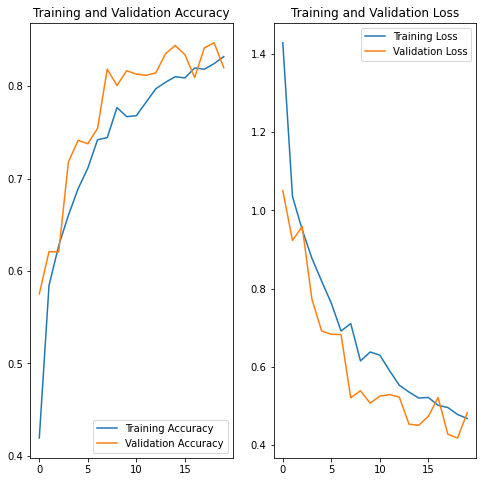

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


intel-image-classification.zip	kaggle.json  saved_model
intel_img			sample_data


In [ ]:
probabilities = model.predict(test_data_gen)


In [ ]:
train_data_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

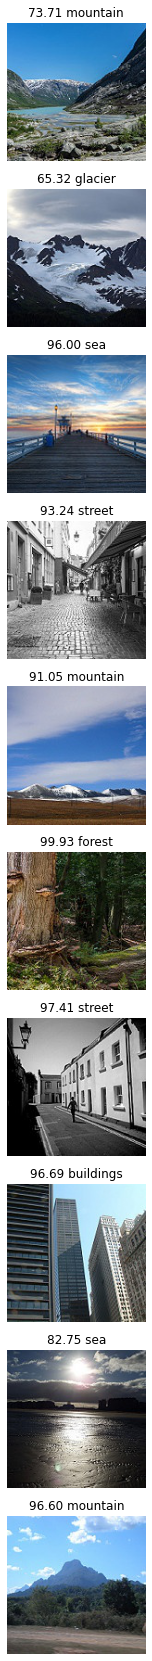

In [ ]:
sample_test_images,_ = next(test_data_gen)
prob = model.predict(sample_test_images)
plotImages(sample_test_images[:10],probabilities=prob)